# Bayesian pooled polling charts (Using PyMC)

## Set-up

In [1]:
# system imports
import itertools
from pathlib import Path
from typing import Any
import re

# analytic imports
import numpy as np
import pandas as pd
import pymc as pm  # type: ignore[import-untyped]
import pytensor as pt
from IPython.display import display

In [2]:
# local import
import bayes_tools
import plotting
from common import MIDDLE_DATE, VOTING_INTENTION, ensure
from data_capture import retrieve

In [3]:
# Useful to check on the version of pymc and pytensor
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on pytensor v{pt.__version__}")

Running on PyMC v5.20.0
Running on pytensor v2.26.4


In [4]:
# plotting related
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

SHOW = True  # show charts in the notebook
SHOW_MODEL_MAPS = False  # show model maps in notebook

## Get data

In [5]:
def data_check(data_dict: dict[str, Any]) -> dict:
    """Pass the latest data and check it for completeness."""

    ensure(data_dict, "You must run the data capture notebook every day.")
    vi = data_dict[VOTING_INTENTION]
    print(vi.Brand.value_counts())
    print(vi.columns)
    should_be_complete = ("ALP", "L/NP", "GRN", "OTH")
    check = [x for x in vi.columns if any(y in x for y in should_be_complete)]
    problematic = vi[vi[check].isnull().sum(axis=1) > 0].index
    if problematic.any():
        print(f"Problematic rows: {problematic}")
        display(vi.loc[problematic])
    return data_dict


data = data_check(retrieve())
vi_data = plotting.amalgamate_other(
    data[VOTING_INTENTION]
)  # important for "Others" category

Brand
Roy Morgan             67
Newspoll               30
Essential 2            29
Essential              21
Resolve Strategic      17
Freshwater Strategy    17
YouGov                 16
Resolve Strategic 2    11
RedBridge Group         9
Newspoll-YouGov         3
Dynata                  1
Wolf & Smith            1
ANU                     1
DemosAU                 1
Name: count, dtype: int64
Index(['Date', 'Brand', 'Interview mode', 'Sample size', 'Primary vote L/NP',
       'Primary vote ALP', 'Primary vote GRN', 'Primary vote ONP',
       'Primary vote UAP', 'Primary vote OTH', '2pp vote ALP', '2pp vote L/NP',
       'First Date', 'Mean Date', 'Last Date'],
      dtype='object')


In [6]:
def last_election() -> pd.Series:
    """Return the results of the last election."""

    previous = pd.read_csv(
        "../historic-data/election-outcomes.csv", sep="\\s+", na_values="-", comment="#"
    )
    previous = previous.dropna(how="all")
    coalition = ["LP", "LNP", "NP", "CLP"]
    previous["Primary vote L/NP"] = previous[coalition].sum(axis=1)
    previous["Primary vote Other"] = (
        100.0 - previous["Primary vote L/NP"] - previous["ALP"] - previous["GRN"]
    )
    previous["Primary vote ALP"] = previous["ALP"]
    previous["Primary vote GRN"] = previous["GRN"]
    previous["2pp vote L/NP"] = 100.0 - previous["Labor2pp"]
    previous["2pp vote ALP"] = previous["Labor2pp"]
    drop_list = [
        "Others",
        "ON",
        "UAP",
        "DEM",
        "DLP",
        "GRN",
        "ALP",
        "Labor2pp",
    ] + coalition
    return previous.drop(columns=drop_list).iloc[-1]


previous_election = last_election()

## Do the Bayesian pooling ...

### The selection of charts to plot

In [7]:
def select_analysis() -> list[tuple[bool, str, str]]:
    # pylint: disable=unused-variable
    """
    Select the charts we will produce ...
    You can choose:
    - whether to use fixed priors and/or prior distributions
    - whether to use a Normal and/or StudentT likelihoods
    - whether to use the GP, GRW and/or GRWLA models
      where GP = Gaussian Process, GRW = Gaussian
      Random walk, and GRWLA is a left anchored GRW.
    Returns a list of tuples. where each
    """

    # -- the analytic possibilities that can be selected
    fixed_priors = False, True
    likelihoods = "Normal", "StudentT"
    approaches = "GRW", "GRWLA", "GP"

    # -- create a range of options for the analysis
    complete_set = list(itertools.product(fixed_priors, likelihoods, approaches))
    fixed_normal_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "Normal"
    ]
    fixed_student_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "StudentT"
    ]
    fixed_gp_only = [x for x in complete_set if x[0] and x[2] == "GP"]  # noqa: F841
    not_fixed_gp_only = [  # noqa: F841
        x for x in complete_set if not x[0] and x[2] == "GP"
    ]
    not_fixed_grw_only = [  # noqa: F841
        x for x in complete_set if not x[0] and "GRW" in x[2]
    ]
    fixed_normal_grw_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "Normal" and x[2] == "GRW"
    ]
    fixed_normal_gp_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "Normal" and x[2] == "GP"
    ]
    fixed_normal_gp_grw = list(  # noqa: F841
        set(fixed_normal_grw_only + fixed_normal_gp_only)
    )

    # -- return the selected analysis option
    return fixed_normal_grw_only


selected_analysis = select_analysis()
print(selected_analysis)

[(True, 'Normal', 'GRW')]


### Identify columns to analyze and plot

In [8]:
def select_data(df: pd.DataFrame) -> tuple[str]:
    # pylint: disable=unused-variable
    """Select the data we will analyze ..."""

    # -- identify the columns we will analyze ...
    frame = ("2pp", "Primary vote")
    columns = sorted([x for x in df.columns if any(item in x for item in frame)])
    majors = ("ALP", "L/NP")
    minors = ("GRN", "Other")
    to_chart = majors + minors

    # -- column options for selected_columns below
    # be careful to turn generator expressions into tuples ..
    all_columns: tuple = tuple(
        c for c in columns if any(item in c for item in to_chart)
    )
    alp_only = tuple(c for c in all_columns if "ALP" in c)  # noqa: F841
    lnp_only = tuple(c for c in all_columns if "L/NP" in c)  # noqa: F841
    tpp_only = tuple(f"2pp vote {x}" for x in majors)  # noqa: F841
    primary_only = tuple(x for x in all_columns if frame[1] in x)  # noqa: F841
    alp_2pp_only = ("2pp vote ALP",)  # noqa: F841
    most_columns = alp_2pp_only + primary_only  # noqa: F841
    minors_pv_only = tuple(f"Primary vote {x}" for x in minors)  # noqa: F841
    majors_pv_only = tuple(f"Primary vote {x}" for x in majors)  # noqa: F841

    # -- return the selected columns
    return all_columns


selected_columns = select_data(vi_data)
print(f"Selected columns: {selected_columns}")

Selected columns: ('2pp vote ALP', '2pp vote L/NP', 'Primary vote ALP', 'Primary vote GRN', 'Primary vote L/NP', 'Primary vote Other')


### Decide whether to plot residuals

In [9]:
# Residuals for infividual polls from the bayesian aggregation
# A sperate plot for each pollster - useful to picking up
# unexplained changed is methodology.

PLOT_RESIDUALS = False

### Values of the fixed priors

In [10]:
def establish_fixed_priors() -> dict:
    """Return a dictionary of fixed priors."""

    # a useful bag of fixed priors
    assumed_sample_size = 750  # assume smallish effective sample
    # sizes polling data is way noisier
    # than published sample size suggest.
    return {
        # --- GRW only fixed priors
        "innovation": 0.175,  # only used with GRW
        # --- GP only fixed priors
        "length_scale": 40,
        "eta": 1.6,
        # --- both GP and GRW fixed priors
        "nu": 10,  # used in StudentT likelihood
        "sigma_likelihood": np.sqrt((50.0 * 50.0) / assumed_sample_size),
    }


fixed_priors_dict = establish_fixed_priors()

### Exclusions from the sum-to-zero constraint on house effects

In [11]:
EXCLUDE = True


def establish_exclusions(df: pd.DataFrame, minimum_polls=5) -> list[str]:
    """Return a tuple of (1) pollsters to include, amd
    (2) pollsters to exclude from the sum-to-zero constraint
    over house effects.
    Arguments:
    - df - the dataframe of the latest polling data
    Returns:
    - a list of pollsters to exclude."""

    exclusions: list[str] = []
    if not EXCLUDE:
        return exclusions

    # -- remove with multiple series (indicated by trailing digits)
    pollsters = df["Brand"].unique()
    pattern = re.compile(r"([^\d]+) (\d+$)")
    for pollster in pollsters:
        if m := re.search(pattern, pollster):
            exclusions.append(m.groups()[0])
        # Note: need to do case where the trailing digit is 3 or greater
    exclusions = list(set(exclusions))

    # -- exclude pollsters with less than minimum_polls
    # This means odd, one-off polls will not effect the positioning
    # of the poll aggregation
    pollster_counts = df["Brand"].value_counts()
    exclude_counts = pollster_counts[pollster_counts < minimum_polls].index.tolist()
    exclusions = list(set(exclusions + exclude_counts))  # ensue no duplicates

    return exclusions


he_sum_exclusions = establish_exclusions(vi_data)
print(f"{len(he_sum_exclusions)} Exclusions: {he_sum_exclusions}")

7 Exclusions: ['Wolf & Smith', 'Resolve Strategic', 'ANU', 'DemosAU', 'Dynata', 'Newspoll-YouGov', 'Essential']


### Key outcomes at the 2022 election

In [12]:
# constants for the left anchored model (GRWLA)
ELECTION_DATE = pd.Period("2022-05-21", freq="D")
last_election_result = {
    "2pp vote ALP": 52.13,
    "2pp vote L/NP": 47.87,
    "Primary vote ALP": 32.58,
    "Primary vote GRN": 12.25,
    "Primary vote L/NP": 35.69,
    "Primary vote Other": 19.48,
}

### Sampler settings

In [13]:
N_CORES: int = 4
SAMPLES: int = 10_000
EXTRA_SAMPLES: int = 25_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
ESAMPLES_PER_CORE: int = int(EXTRA_SAMPLES / N_CORES)
TUNE: int = 1_000

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
}

print(SAMPLE_ARGS)

{'draws': 2500, 'tune': 1000, 'cores': 4, 'chains': 4, 'nuts_sampler': 'numpyro'}


### Do the analysis and produce the plots

In [14]:
def check_inputs(inputs_: dict) -> None:
    """Double check that the sum to zero constraint is correctly applied."""

    he_contrained = inputs_["he_sum_inclusions"]
    he_inclusions2 = inputs_["firm_list"][: len(he_contrained)]
    ensure(
        set(he_contrained) == set(he_inclusions2),
        "Pollster House Effect lists do not match.",
    )

2pp vote ALP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2882.0
Divergences: 0


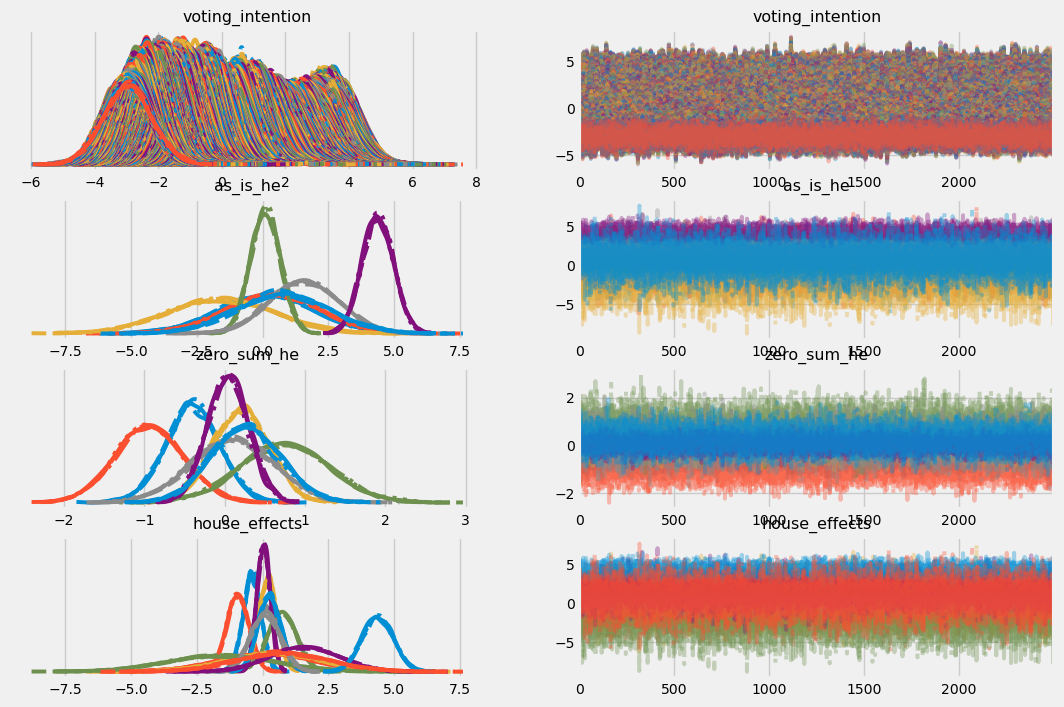

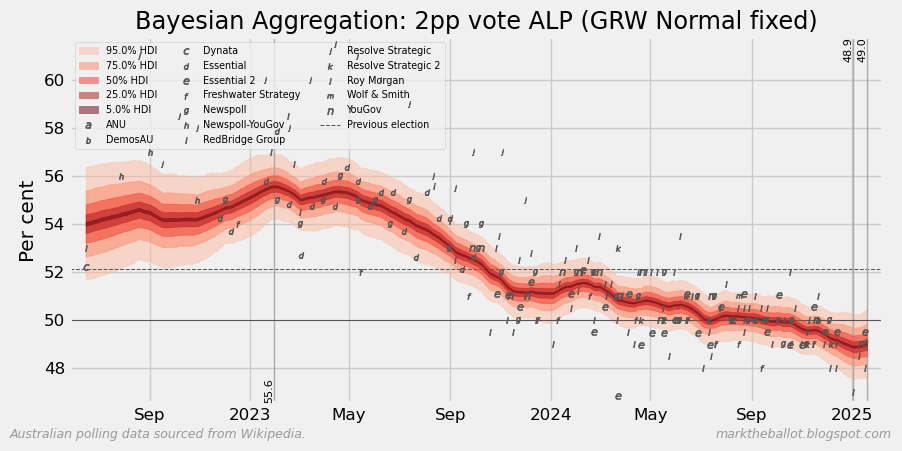

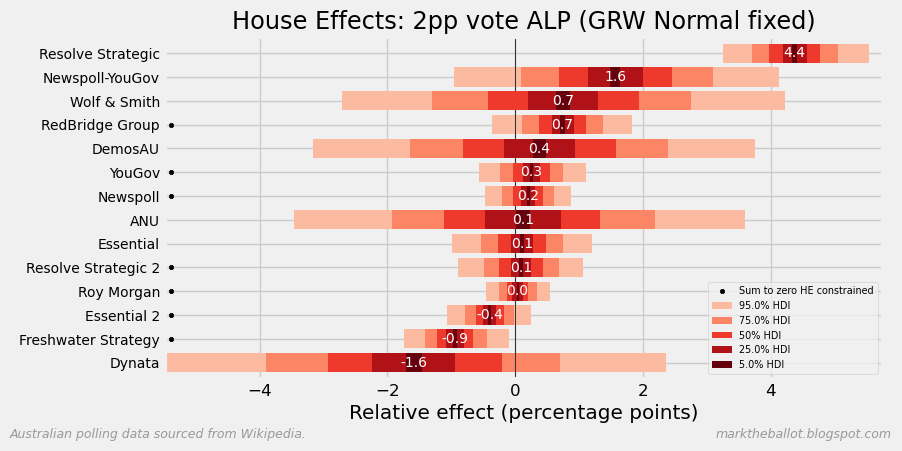

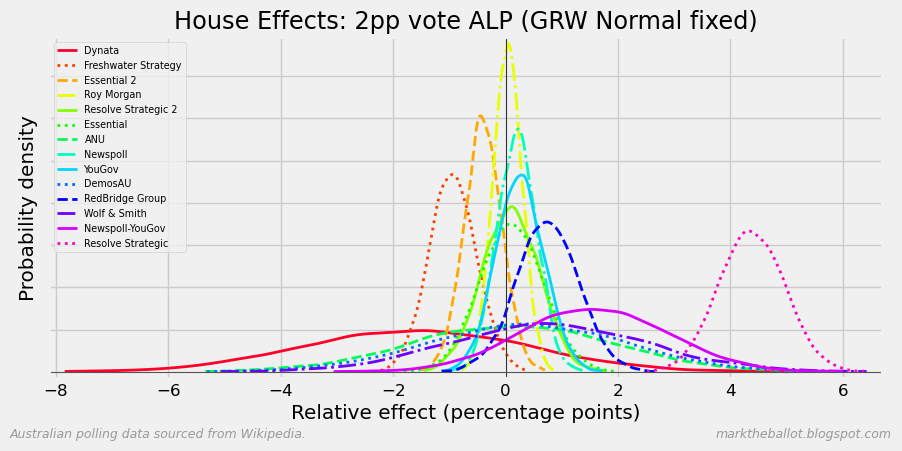

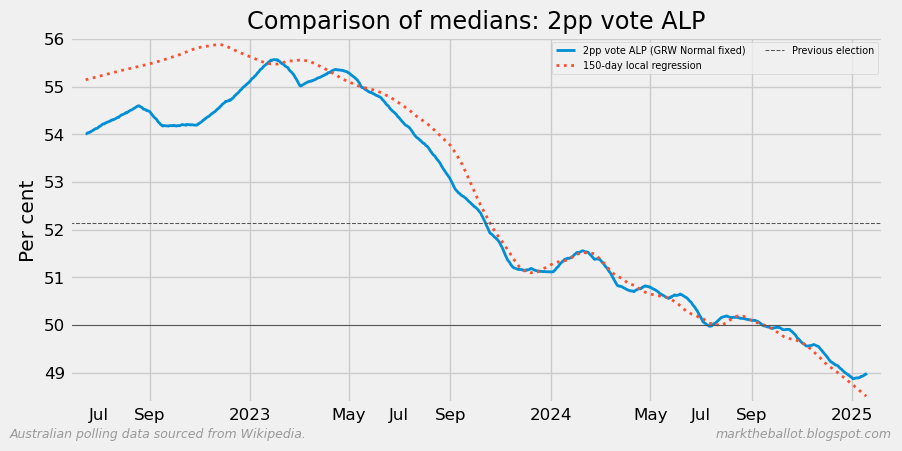

2pp vote L/NP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2667.0
Divergences: 0


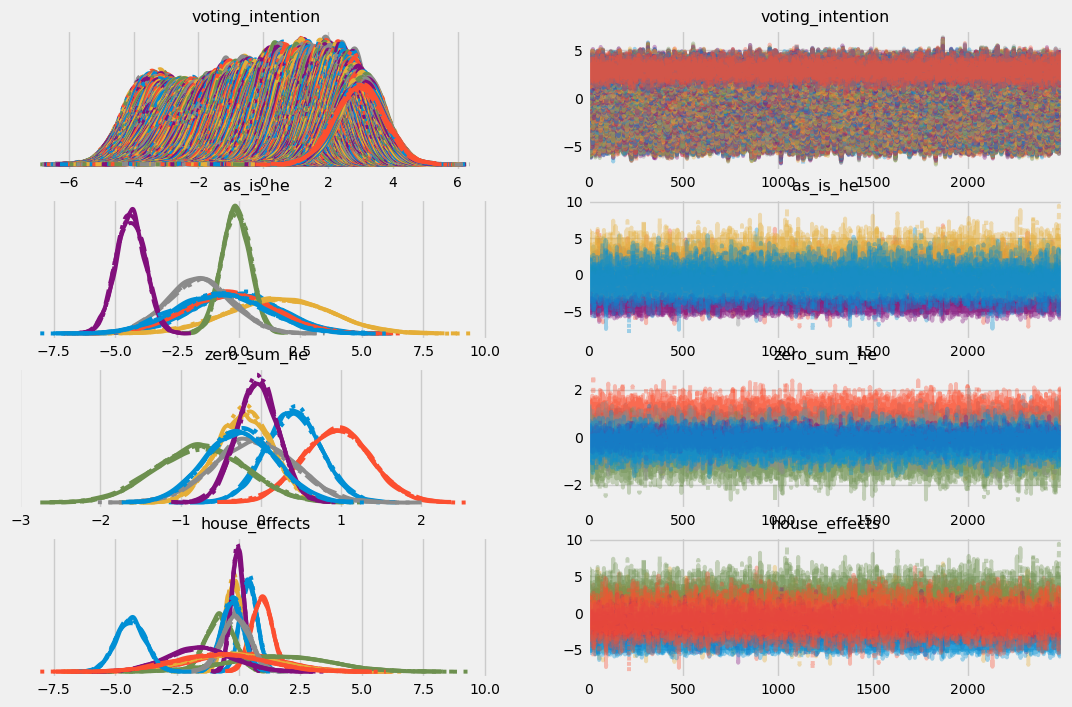

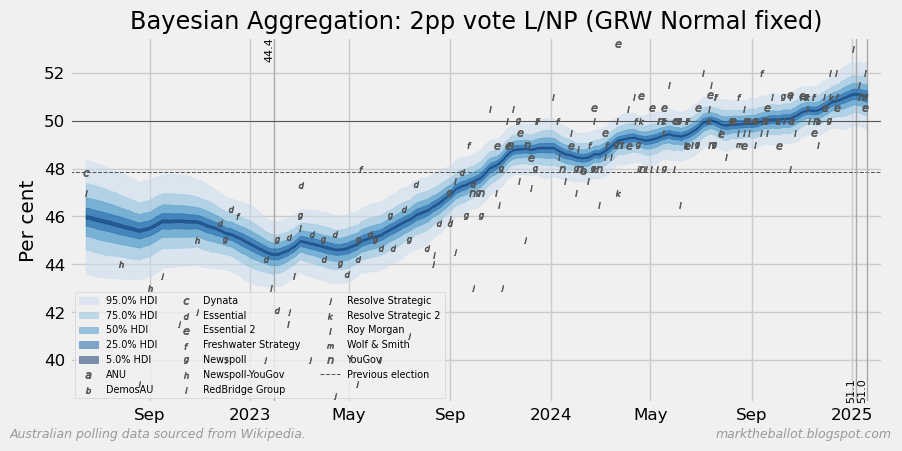

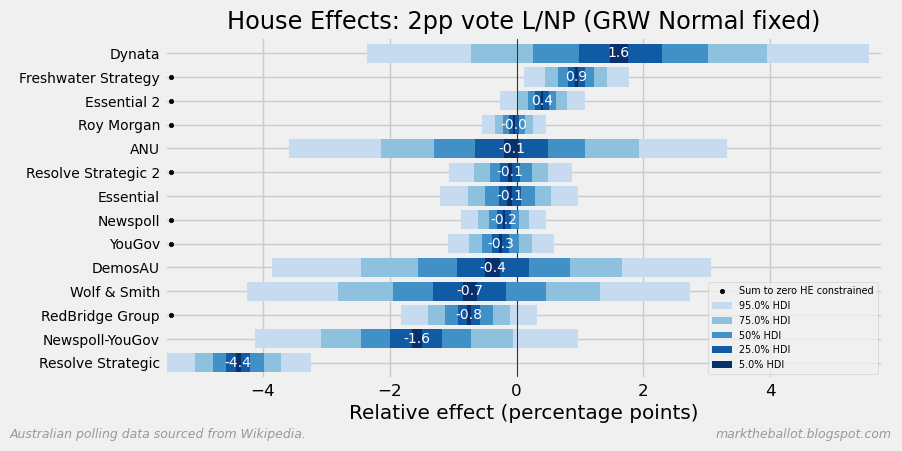

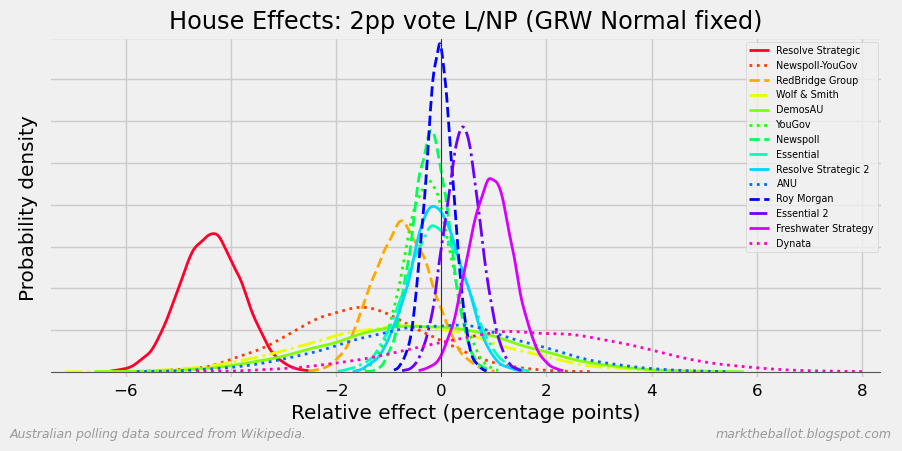

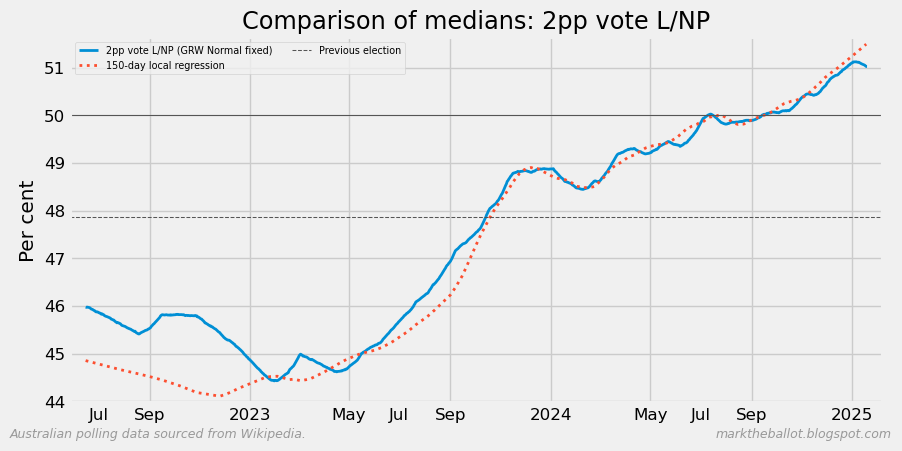

Primary vote ALP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2887.0
Divergences: 0


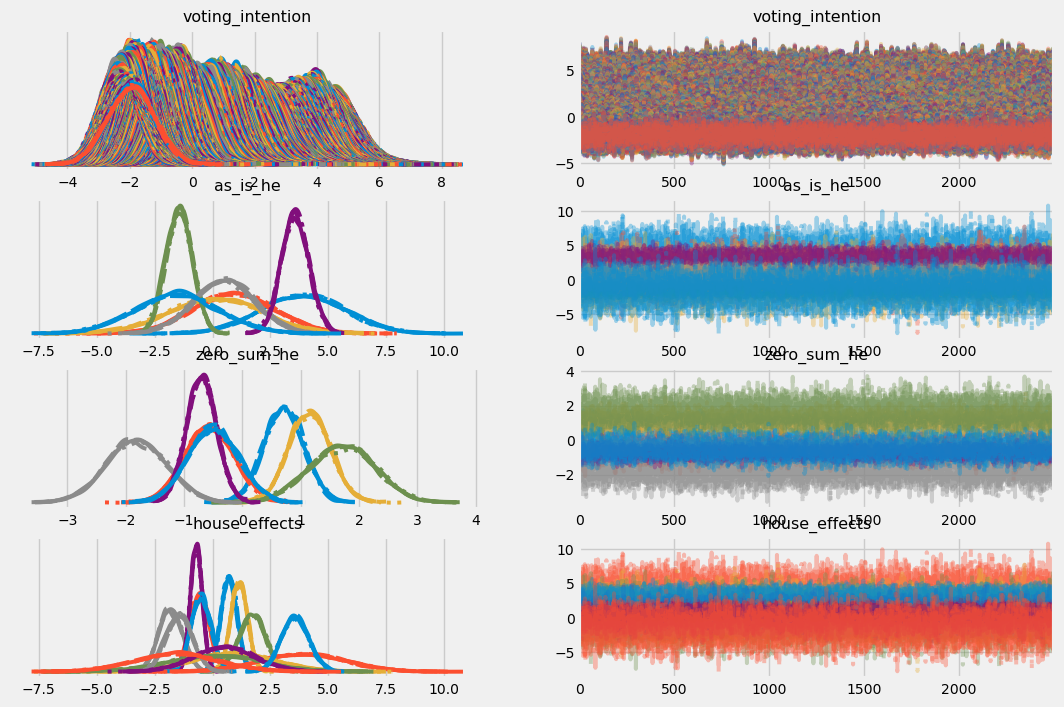

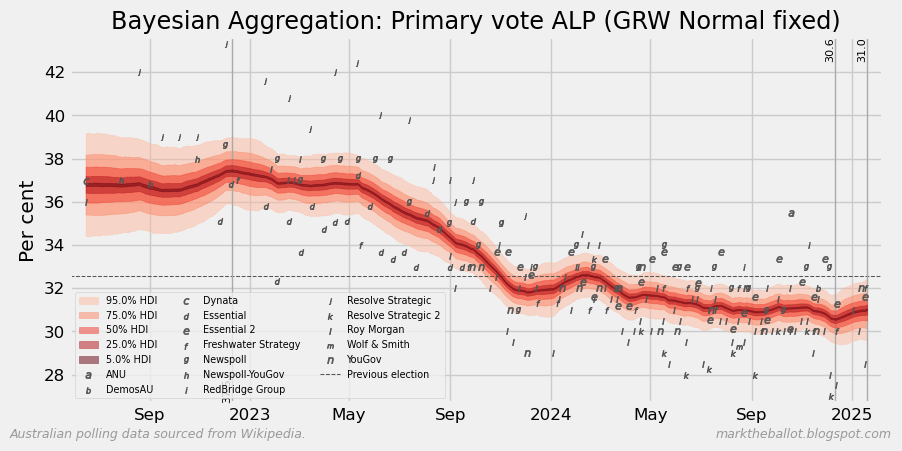

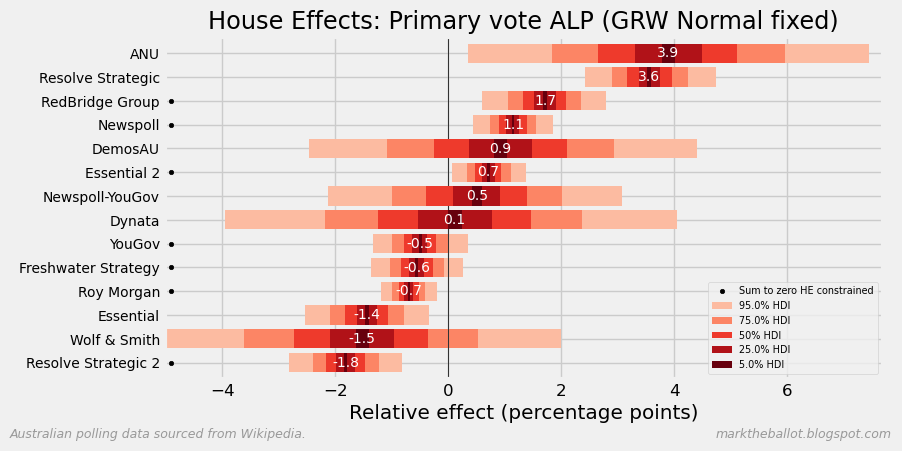

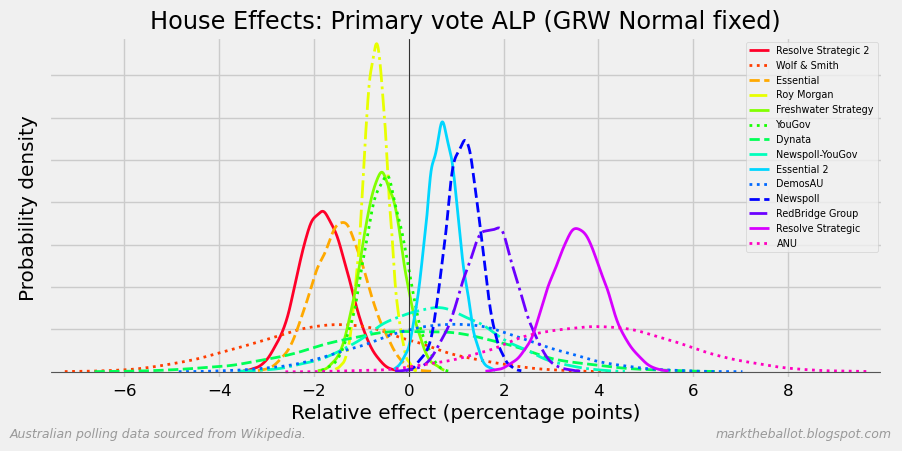

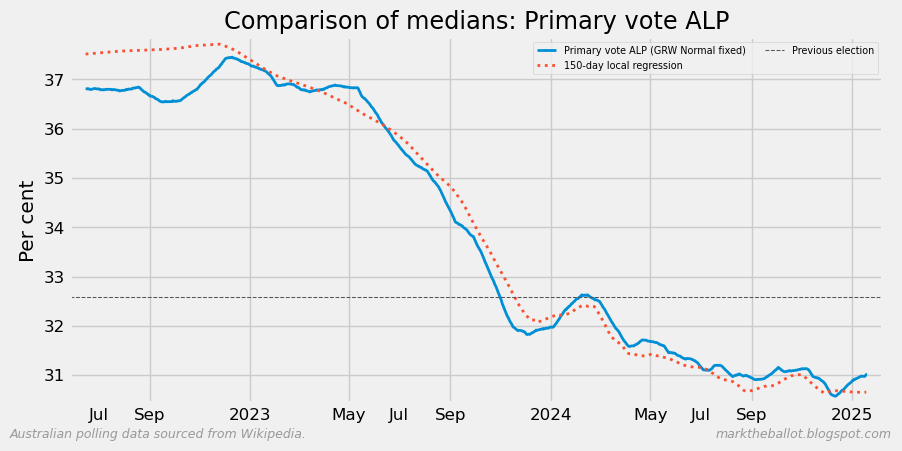

Primary vote GRN (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2763.0
Divergences: 0


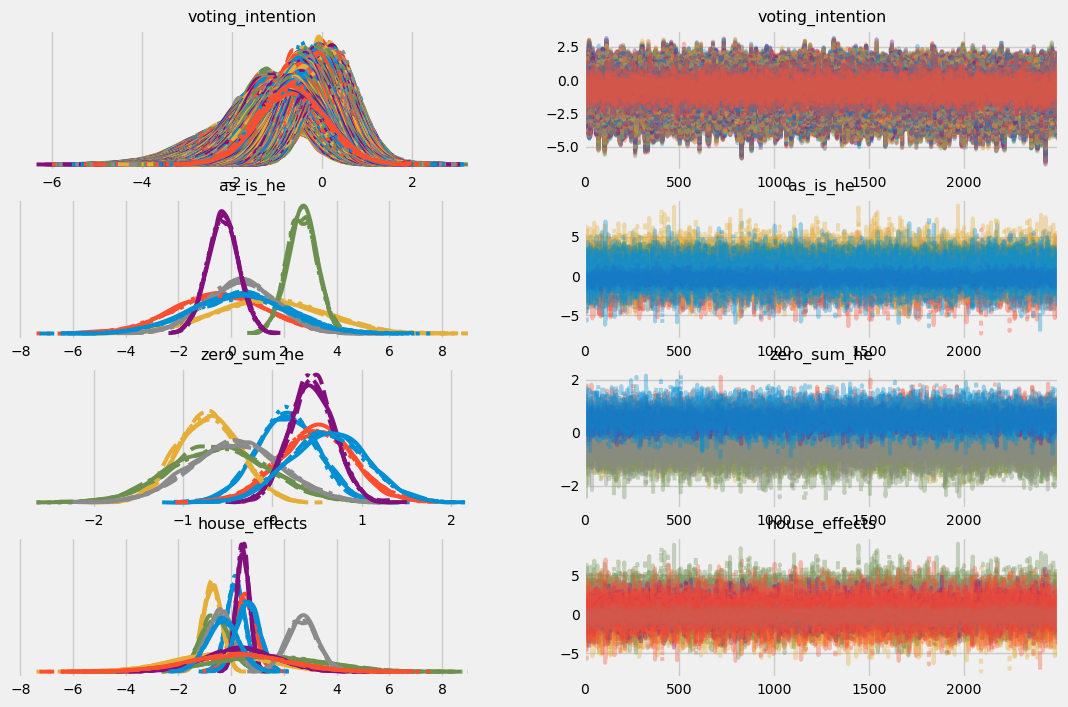

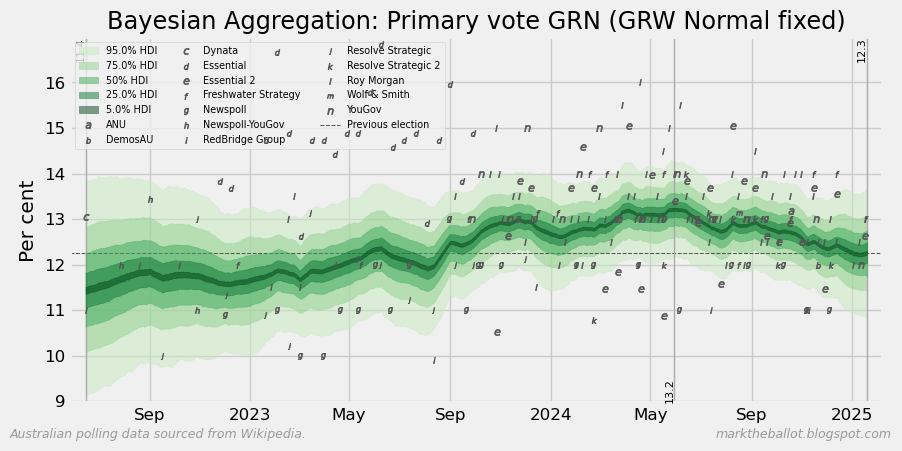

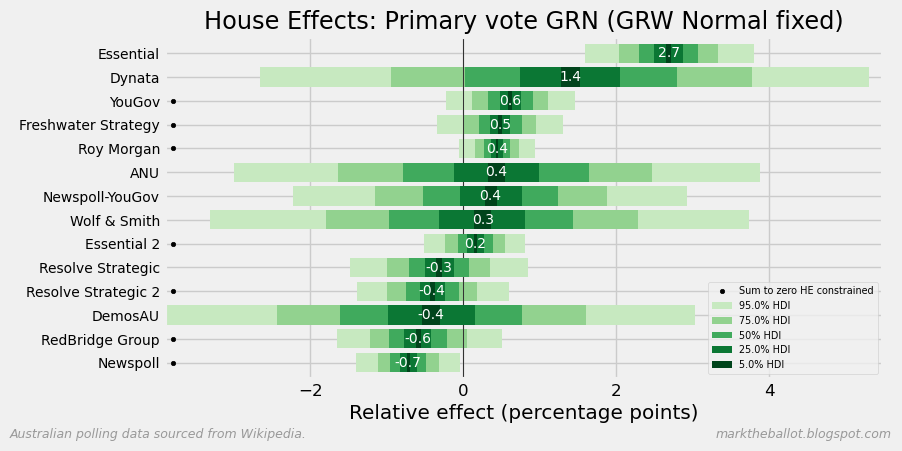

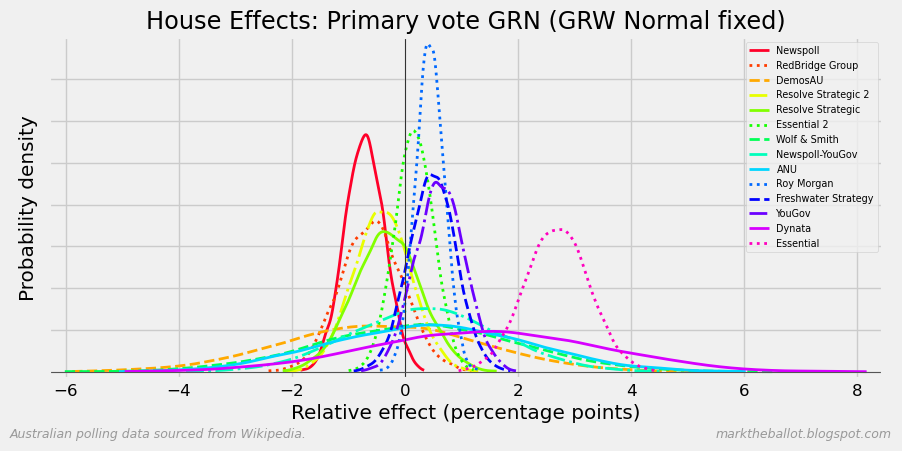

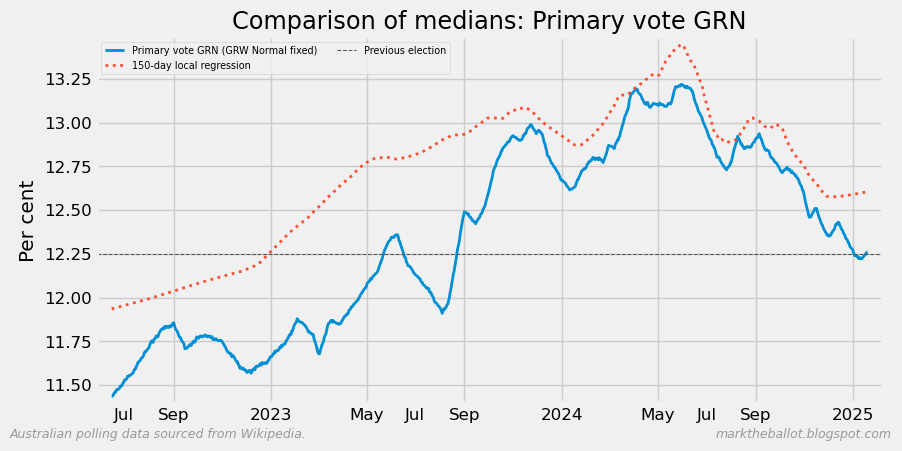

Primary vote L/NP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 3209.0
Divergences: 0


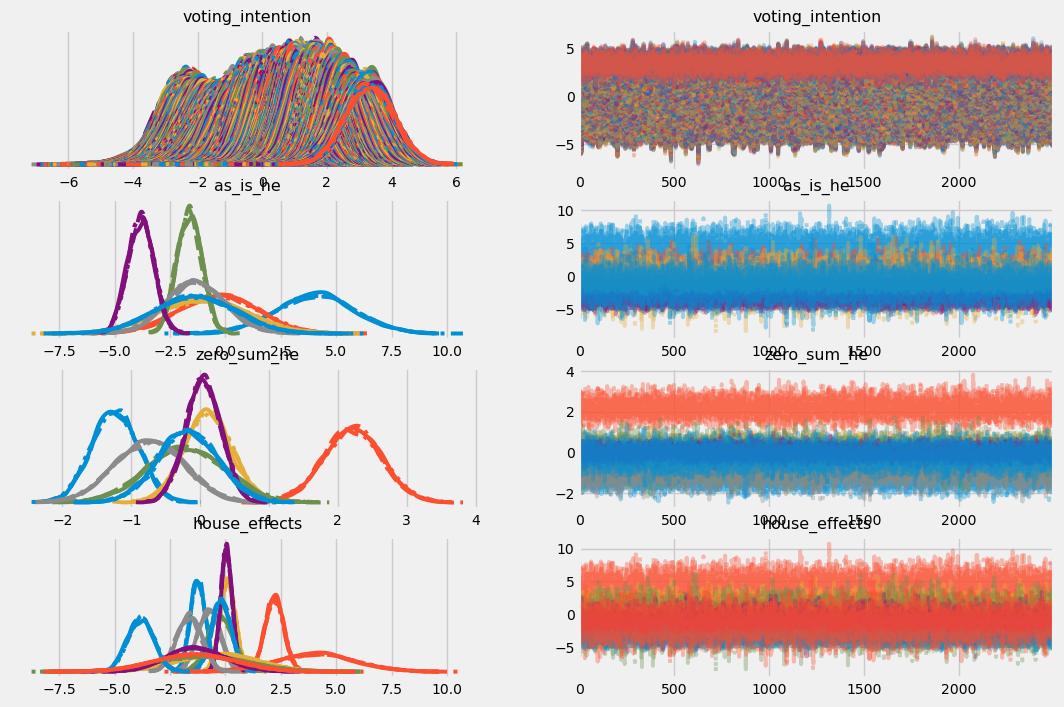

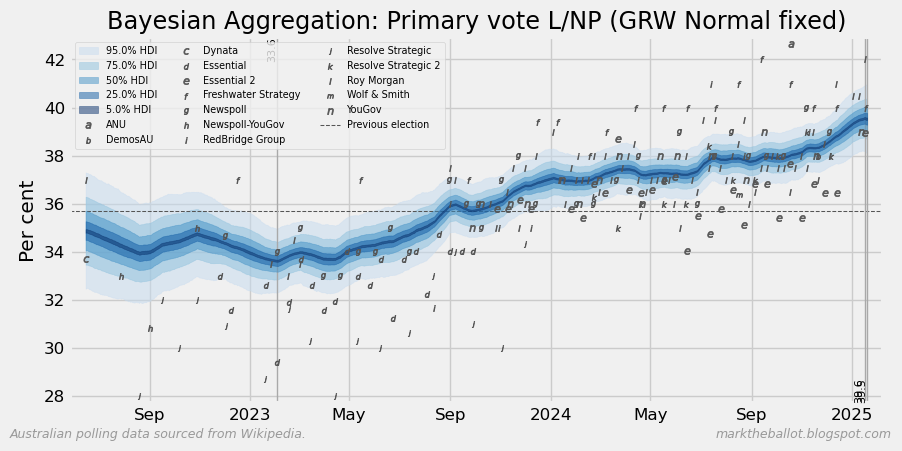

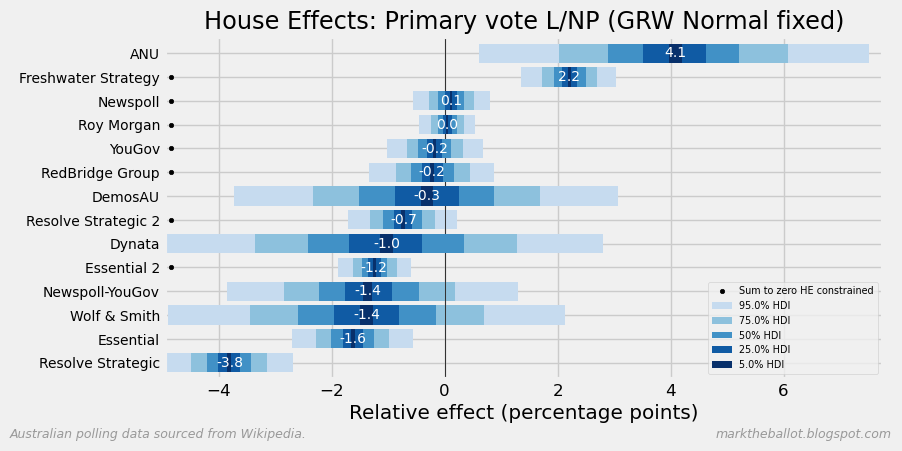

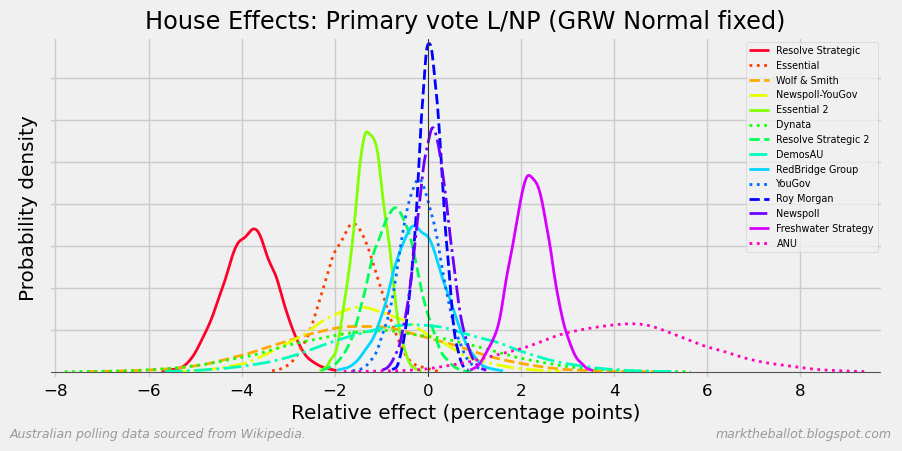

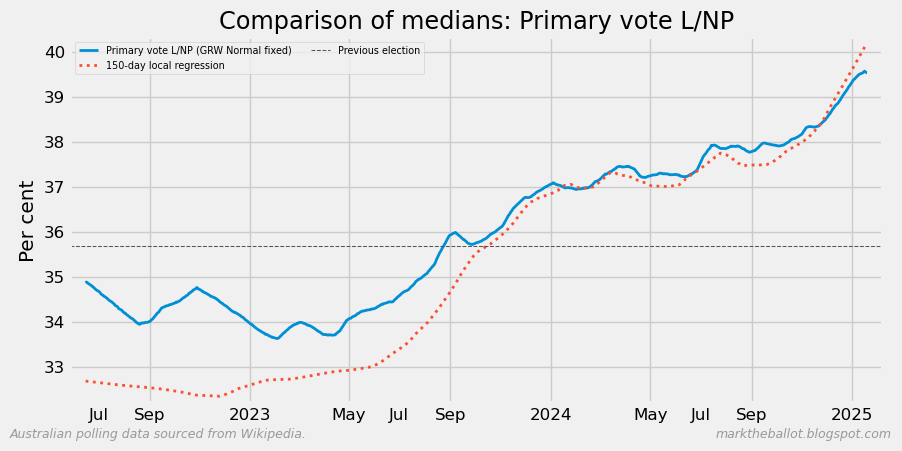

Primary vote Other (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 3126.0
Divergences: 0


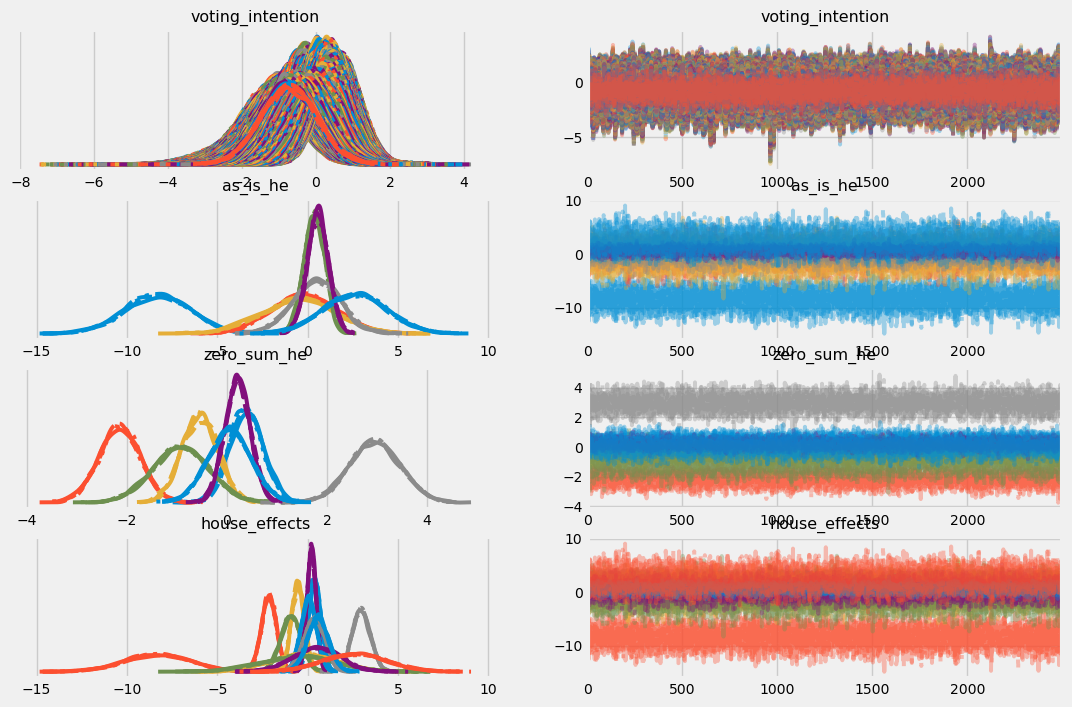

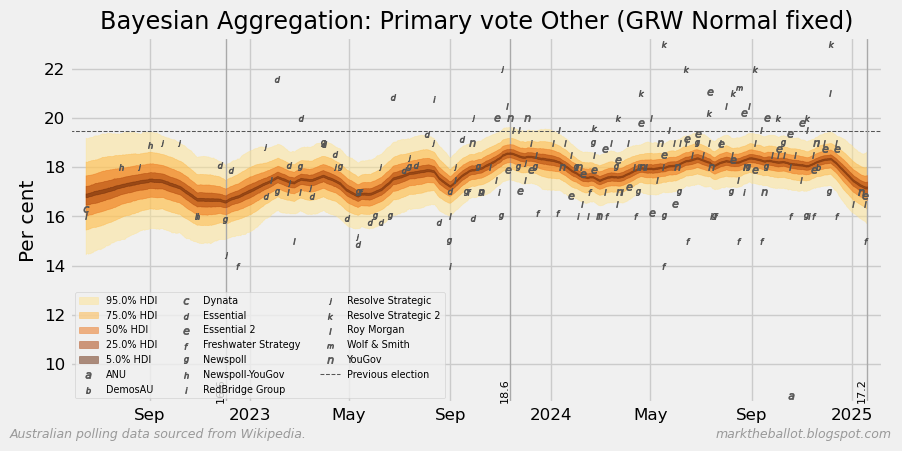

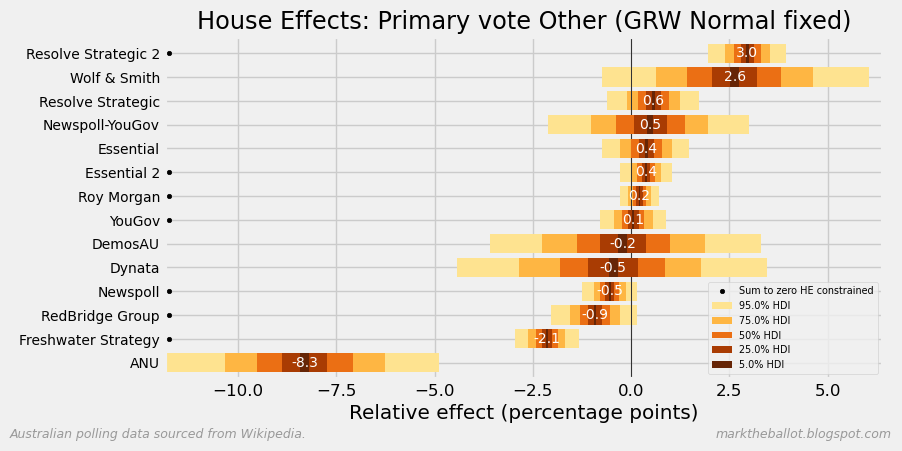

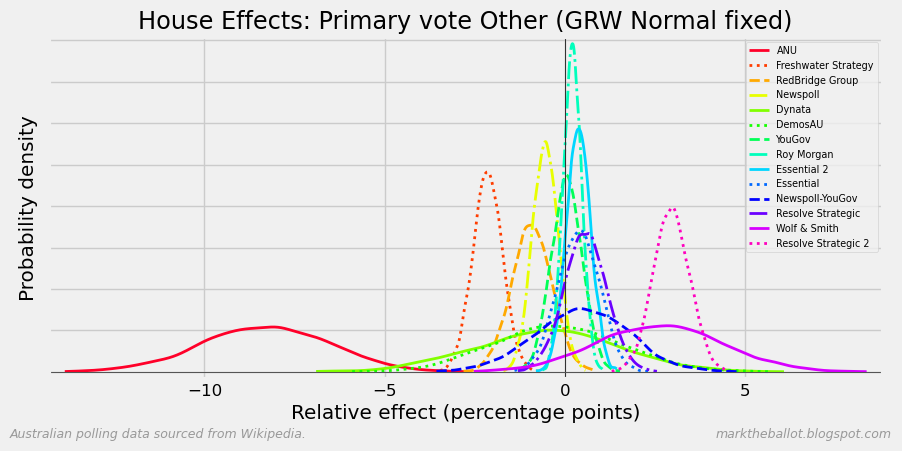

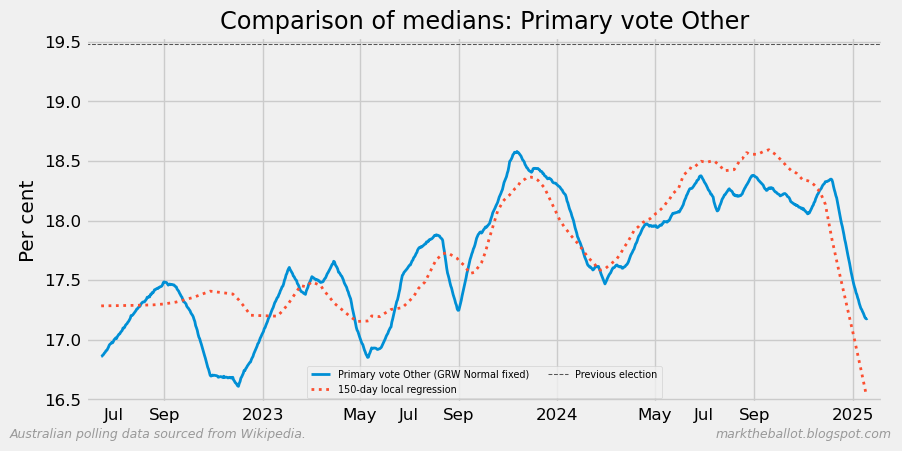

In [15]:
for column in selected_columns:
    median_sets = {}

    for fixed, likelihood, approach in selected_analysis:
        FIXED_TEXT = "fixed" if fixed else "free"
        MODEL_TITLE = f"{column} ({approach} {likelihood} {FIXED_TEXT})"
        print(MODEL_TITLE)

        # -- get the relevant data then select and run the model
        # Note: I could not get the GRW to mix well without specifying innovation.
        #       Similarly, specifying sigma_likelihood is useful.
        keep_fixed = ("innovation", "sigma_likelihood")
        priors = (
            fixed_priors_dict
            if fixed
            else {x: fixed_priors_dict[x] for x in keep_fixed}
        )
        sampling = SAMPLE_ARGS.copy()

        match approach:
            case "GP":
                inputs = bayes_tools.prepare_data_for_analysis(
                    vi_data,
                    column,
                    jitter_dates=True,
                    tail_centred=10,
                    he_sum_exclusions=he_sum_exclusions,
                    verbose=False,
                )
                check_inputs(inputs)
                model = bayes_tools.gp_model(
                    inputs,
                    **priors,
                    likelihood=likelihood,
                    grw=False,
                    eta_prior="HalfCauchy",  # only used if eta not in **priors
                )
            case "GRW":
                inputs = bayes_tools.prepare_data_for_analysis(
                    vi_data,
                    column,
                    he_sum_exclusions=he_sum_exclusions,
                    verbose=False,
                )
                check_inputs(inputs)
                model = bayes_tools.grw_model(inputs, **priors, likelihood=likelihood)
            case "GRWLA":
                inputs = bayes_tools.prepare_data_for_analysis(
                    vi_data,
                    column,
                    left_anchor=(ELECTION_DATE, last_election_result[column]),
                    he_sum_exclusions=he_sum_exclusions,
                    verbose=False,
                )
                check_inputs(inputs)
                sampling |= {"draws": ESAMPLES_PER_CORE, "nuts": {"max_treedepth": 12}}
                model = bayes_tools.grw_la_model(
                    inputs, **priors, likelihood=likelihood
                )
            case _:
                print("Unknown approach")
                continue

        bayes_tools.generate_model_map(
            model=model,
            filemame_stem=MODEL_TITLE,
            model_dir=MODEL_DIR,
            display_images=SHOW_MODEL_MAPS,
        )

        idata, glitches = bayes_tools.draw_samples(model, **sampling)

        middle = bayes_tools.plot_std_set(
            inputs,
            idata,
            previous_election[column],
            title_stem=MODEL_TITLE,
            glitches=glitches,
            residuals=PLOT_RESIDUALS,
            show=SHOW,
        )
        if not glitches:
            median_sets[MODEL_TITLE] = middle

    # Add a local regression to the combined plot
    PERIOD_DAYS = 150  # days
    loess = plotting.calculate_lowess(
        series=pd.Series(vi_data[column].values, index=vi_data[MIDDLE_DATE]),
        frac_period=PERIOD_DAYS,
    )
    if loess is not None:
        median_sets[f"{PERIOD_DAYS}-day local regression"] = loess

    # -- summary plot for each column
    _, ax = plotting.initiate_plot()
    styles = plotting.STYLES * 4
    for index, (name, series) in enumerate(median_sets.items()):
        series.plot(ax=ax, ls=styles[index], lw=2, label=name)
    axhline = ax.axhline(
        y=previous_election[column],
        color="#555555",
        lw=0.75,
        ls="--",
        label="Previous election",
    )
    ax.legend(loc="best", fontsize="xx-small", ncols=2)
    plotting.finalise_plot(
        ax,
        title=f"Comparison of medians: {column}",
        ylabel="Per cent",
        y50=True,
        concise_dates=True,
        **plotting.footers,
        show=SHOW,
    )

## Finished

In [16]:
%load_ext watermark
%watermark --python --machine --iversions --watermark

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas  : 2.2.3
pymc    : 5.20.0
numpy   : 1.26.4
re      : 2.2.1
IPython : 8.31.0
pytensor: 2.26.4

Watermark: 2.5.0



In [17]:
print("Finished")

Finished
